# Advanced Regression

## Introduction
Surprise Housing uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia.

## Business Objective
Surprise housing wants us to model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

## Problem Statement
The company wants to purchase houses at a price below their actual values and flip them on at a higher price. For this, the comany is looking at prospective properties to buy to enter the market. The company wants us to build a model that enables to predict the actual value of the prospective properties and decide whether to invest in them or not.

The company wants to know:
- Which variables are significant in predicting the price of a house, and
- How well those variables describe the price of a house.

## About the Dataset
The company has collected and shared a data set from the sale of houses in Australia . The data is provided in the form of a CSV file (**train.csv**). The company has also provided the data dictionary for the variables which are part of the historical data (**AdvancedRegression.txt**) 

### Data Specifications
The data has list of sale records of houses in Australia for the sale year between 2006 and 2010. Some of the specifications are as follows:
- There are **81 columns** in the dataset.
- There are **1460 records** in the dataset. 
- The target variable here is the **SalePrice** column.
- The SalePrice is a continuous variable and hence we will use Linear Regression model to predict the SalePrice.


### Importing Python packages and loading the dataset

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from IPython.display import display

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

sns.set()
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

data = pd.read_csv("E:\\UpGrad\\ProjData\\Advanced_Regression\\train.csv")

### EDA Utility functions
Below are the list of functions which will aid in the performing the EDA on the input data. Some of these functions are as below:
- List the NULL records Percentage in the dataset: *nullRec*
- Delete the columns from the dataset: *delCol*
- Function to create only 2 segments for pie chart: *convert_dat_label*

In [80]:
## Null records
def nullRec(data):
    temp=data[data.columns[data.isnull().sum() > 0]].isnull().sum()
    temp=temp.apply(lambda x: (x/len(data)*100))
    return temp

## To delete the columns
def delCol(data,col_list):
    data = data.loc[:,~data.columns.isin(col_list)]
    return data

# Function to create only 2 segments for pie chart: One for majority column and the other that contains rest of the values
def convert_dat_label(total, val):
    dat = list(val)
    dat.append(total-dat[0])
    label = list(val.keys())
    label.append("Rest of the Values")
    return dat, label

### Removal of column by the name *Id*
The Id column doesnt carry any useful information and hence we will remove this from the dataset

In [81]:
data = delCol(data,['Id'])

### Analysis of NULL records
Using the utility fucntion *nullRec*, we came up with the below observations
- **Alley, PoolQC, Fence, MiscFeature** have more than **80%** of the data as NULL
- **MasVnrType, MasVnrArea, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, Electrical** columns have less than **2.5%** of their data NULL
- **FireplaceQu**, though has **47%** of its data NA, they actually refers to the No Fireplace. **This is not NULL records and hence we need to impute this category with a more meaningful category**.
- **LotFrontage** has close to **18%** of its data missing.
- **GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond** has close to **5%** of its data missing, but the data is missing across all the columns under the same record.

### Handling the NULL values
Below are the set of actions that i have taken to handle the missing data:
- For **Alley, PoolQC, Fence, MiscFeature**, since they have more than 80% of the data missing, we will delete those columns
- For **MasVnrType, MasVnrArea, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, Electrical**, since less than 2.5% of the records are missing, we will delete those rows.
- For **FireplaceQu**, since the 47% of the missing data is actually **No Fireplace** and not NULL value, we will replace **NA** with **NO Fireplace** category.
- For **LotFrontage**, since 18% of missing data is sizable, we **won't delete the records**. Instead, we will impute the missing values with the mean value of the population of LotFrontage. This is performed so that the data distribution/stat is not altered.
- For **GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond**, since they have only 5% of missing data, and that they are under the same record, it wont result in deletion of substantial data. Hence we will delete records which has these values as NULL.

### Code to handle the missing data

In [82]:
## Get the columns with NULL values
temp = nullRec(data)
#temp

## Remove Alley, PoolQC, Fence, MiscFeature as they have more than 80% of the data as NULL
col_list = ['Alley', 'PoolQC', 'Fence', 'MiscFeature','Id']
data = delCol(data,col_list)

## Delete records of MasVnrType, MasVnrArea, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, Electrical
data_temp = data.loc[~(data['MasVnrType'].isna() | data['BsmtQual'].isna() | data['BsmtExposure'].isna()),:]
data = data_temp.loc[~(data_temp['BsmtFinType2'].isna() | data_temp['Electrical'].isna()),:]

# For Fireplace, NA refers to no fireplace. Hence we will replace NA values with 'No Fireplace', which means no fireplace
data['FireplaceQu'] = data['FireplaceQu'].apply(lambda x: 'No Fireplace' if str(x).lower()=='nan' else x)

# data['LotFrontage']: 251 count of missing data , mean of 70 and mode of 60
# Since 251 is a huge number of records to omit, we will replace it with the mean value of 70 so that the data distribution/stat is not altered
data['LotFrontage'] = data['LotFrontage'].apply(lambda x: 70 if np.isnan(float(x)) else x)

#'GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond' have NA for the same records. Since 5% of the data is something that we can remove with causing a major loss of data, we will remove the records which have NA value
data = data.loc[~(data['GarageType'].isna()),:]

## Code to visualize the missing data. Should return empty list after running the above scripts
temp = nullRec(data)
print(temp)

#data.isnull().sum()

Series([], dtype: float64)


### Handling the Duplicate data
**Street, Utilities, LandSlope, Condition2, RoofMatl, Heating, LowQualFinSF, PoolArea** columns have more than **97%** of duplicate data. This is highly skewed data and wont aid in the model development. Hence removing these columns


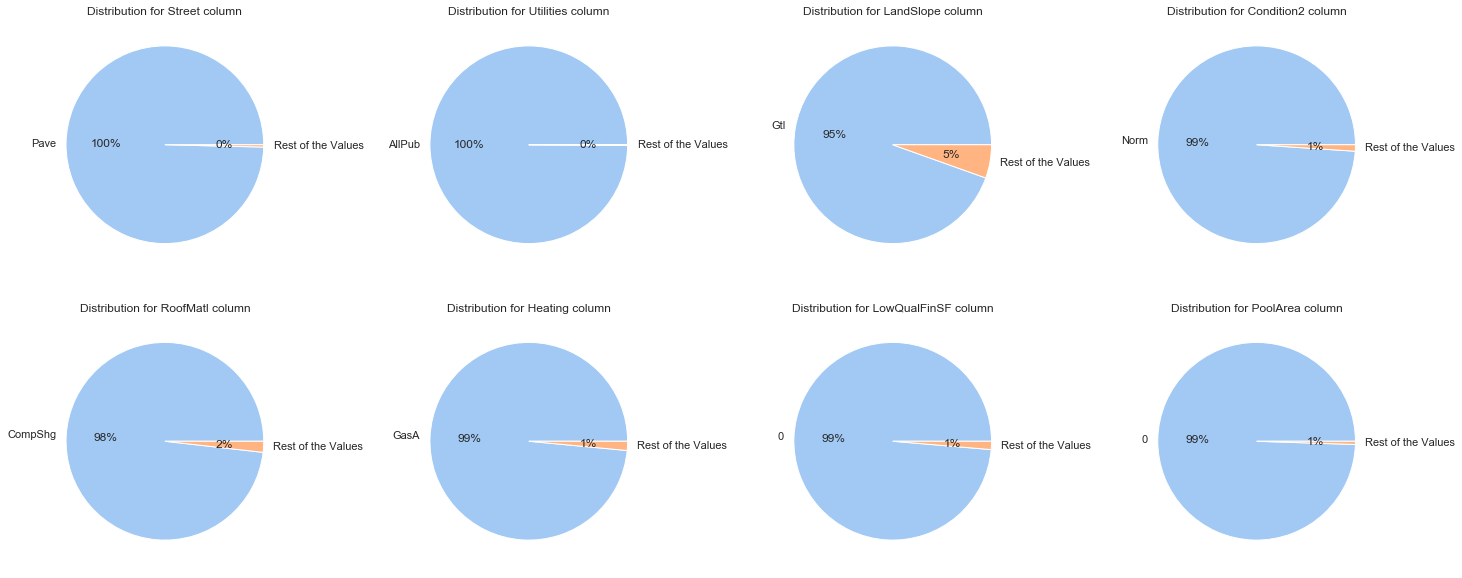

In [83]:
# Code to set the grid for box plots and pie charts
fig, axis = plt.subplots(2,4,figsize=(25, 10))
colors = sns.color_palette('pastel')[0:5]
total = len(data)

# Code go get the params for the pie chart
dat_Street, label_Street = convert_dat_label(total,data["Street"].value_counts()[data["Street"].value_counts()>100]) 
dat_Utilities, label_Utilities = convert_dat_label(total,data["Utilities"].value_counts()[data["Utilities"].value_counts()>100]) 
dat_LandSlope, label_LandSlope = convert_dat_label(total,data["LandSlope"].value_counts()[data["LandSlope"].value_counts()>100])
dat_Condition2, label_Condition2 = convert_dat_label(total,data["Condition2"].value_counts()[data["Condition2"].value_counts()>100]) 
dat_RoofMatl, label_RoofMatl = convert_dat_label(total,data["RoofMatl"].value_counts()[data["RoofMatl"].value_counts()>100]) 
dat_Heating, label_Heating = convert_dat_label(total,data["Heating"].value_counts()[data["Heating"].value_counts()>100])
dat_LowQualFinSF, label_LowQualFinSF = convert_dat_label(total,data["LowQualFinSF"].value_counts()[data["LowQualFinSF"].value_counts()>100]) 
dat_PoolArea, label_PoolArea = convert_dat_label(total,data["PoolArea"].value_counts()[data["PoolArea"].value_counts()>100]) 


# Code to plot the pi chart to capture the skwness of those 3 columns
axis[0,0].pie(list(dat_Street),labels=label_Street,colors = colors, autopct='%.0f%%')
axis[0,1].pie(list(dat_Utilities),labels=label_Utilities,colors = colors, autopct='%.0f%%')
axis[0,2].pie(list(dat_LandSlope),labels=label_LandSlope,colors = colors, autopct='%.0f%%')
axis[0,3].pie(list(dat_Condition2),labels=label_Condition2,colors = colors, autopct='%.0f%%')
axis[1,0].pie(list(dat_RoofMatl),labels=label_RoofMatl,colors = colors, autopct='%.0f%%')
axis[1,1].pie(list(dat_Heating),labels=label_Heating,colors = colors, autopct='%.0f%%')
axis[1,2].pie(list(dat_LowQualFinSF),labels=label_LowQualFinSF,colors = colors, autopct='%.0f%%')
axis[1,3].pie(list(dat_PoolArea),labels=label_PoolArea,colors = colors, autopct='%.0f%%')

axis[0,0].set(title="Distribution for Street column")
axis[0,1].set(title="Distribution for Utilities column")
axis[0,2].set(title="Distribution for LandSlope column")
axis[0,3].set(title="Distribution for Condition2 column")
axis[1,0].set(title="Distribution for RoofMatl column")
axis[1,1].set(title="Distribution for Heating column")
axis[1,2].set(title="Distribution for LowQualFinSF column")
axis[1,3].set(title="Distribution for PoolArea column")



# Code to remove Street, Utilities, LandSlope, Condition2, RoofMatl, Heating, LowQualFinSF, PoolArea columns
col_list = ['Street', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl', 'Heating', 'LowQualFinSF', 'PoolArea']
data = delCol(data,col_list)

### Data Transformation
The column **GarageYrBlt** actually represents the year. But its in integer format. We need to transform this to an integer to get better interpretation out of it.

In [84]:
# Converting GarageYrBlt to integer from float
data['GarageYrBlt'] = data['GarageYrBlt'].apply(lambda x: int(x))


### Handling the outliers for continuous variable

Upon analyzing the continuous varibles in the dataset, we found that are there are close to 6 variables which has completely skewed data i.e there are a large number of zero values. Of these 6, 3 variables have more than 90% of its data equal to zero. This will render the variable irrelevent for analysis, as they dont carry any useful information or pattern.

The 3 variables are **MiscVal, ScreenPorch, 3SsnPorch**. The below distribution reveals that patter.

Since these variables dont carry any useful pattern, i would prefer to remove these columns from the dataset.

#### Code to handle outliers for continuous variable

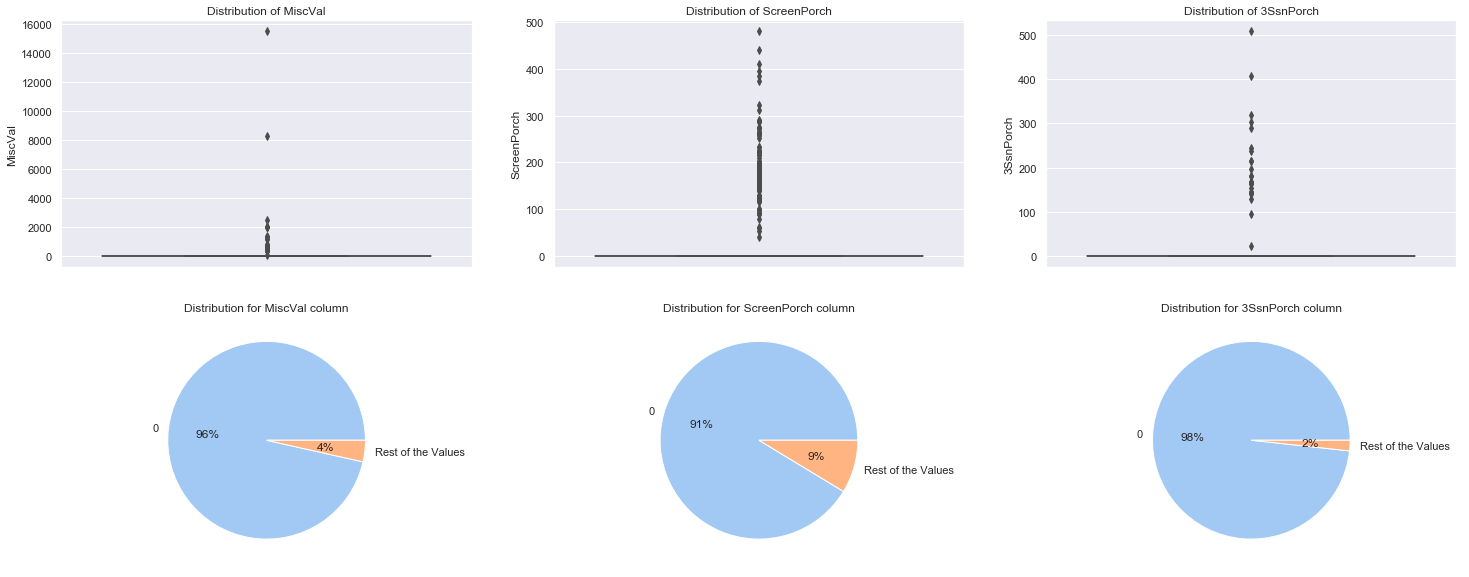

In [85]:
#data.describe()

# Code to set the grid for box plots and pie charts
fig, axis = plt.subplots(2,3,figsize=(25, 10))
colors = sns.color_palette('pastel')[0:5]
total = len(data)

# Code go get the params for the pie chart
dat_MiscVal, label_MiscVal = convert_dat_label(total,data["MiscVal"].value_counts()[data["MiscVal"].value_counts()>100]) 
dat_ScreenPorch, label_ScreenPorch = convert_dat_label(total,data["ScreenPorch"].value_counts()[data["ScreenPorch"].value_counts()>100]) 
dat_3SsnPorch, label_3SsnPorch = convert_dat_label(total,data["3SsnPorch"].value_counts()[data["3SsnPorch"].value_counts()>100])

# Code to plot the boxplot to capture the data distribution for those 3 columns
sns.boxplot(y = data['MiscVal'],ax=axis[0,0]).set(title="Distribution of MiscVal")
sns.boxplot(y = data['ScreenPorch'],ax=axis[0,1]).set(title="Distribution of ScreenPorch")
sns.boxplot(y = data['3SsnPorch'],ax=axis[0,2]).set(title="Distribution of 3SsnPorch")

# Code to plot the pi chart to capture the skwness of those 3 columns
axis[1,0].pie(list(dat_MiscVal),labels=label_MiscVal,colors = colors, autopct='%.0f%%')
axis[1,1].pie(list(dat_ScreenPorch),labels=label_ScreenPorch,colors = colors, autopct='%.0f%%')
axis[1,2].pie(list(dat_3SsnPorch),labels=label_3SsnPorch,colors = colors, autopct='%.0f%%')
axis[1,0].set(title="Distribution for MiscVal column")
axis[1,1].set(title="Distribution for ScreenPorch column")
axis[1,2].set(title="Distribution for 3SsnPorch column")

# Code to delete the columns "MiscVal", "ScreenPorch", "3SsnPorch"
col_list = ["MiscVal", "ScreenPorch", "3SsnPorch"]
data = delCol(data,col_list)

### Analyzing the correlation between the target variable and the continuous variables
I tried to extract the correlation between some of the continuous variables and the target variable SalePrice. Some of the columns for which we are trying to understand the correlation with **SalePrice** are **GrLivArea, LotArea, OverallQual, 1stFlrSF, YearBuilt**.

#### PairPlot analysis

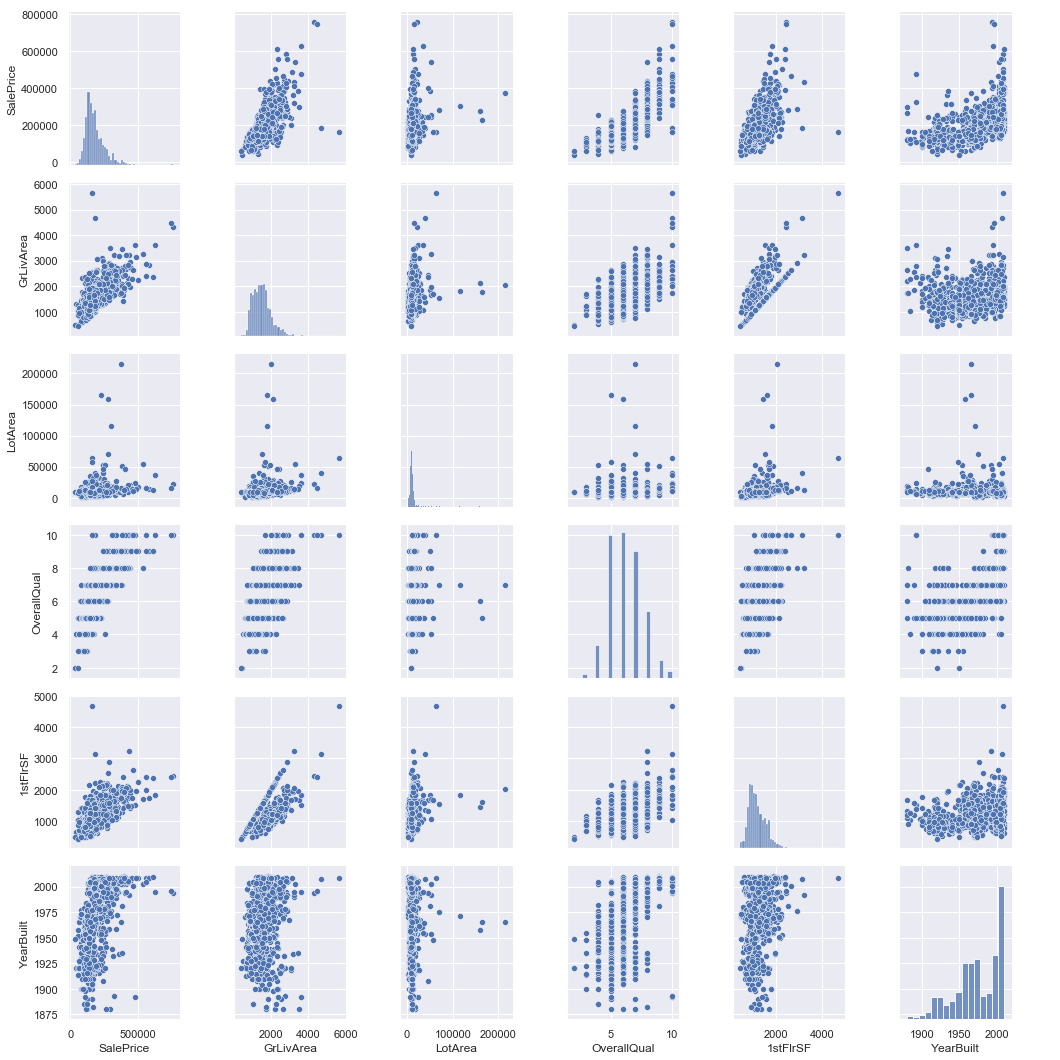

In [86]:
# Code for the pairplot analysis
col_list = ['SalePrice','GrLivArea','LotArea','OverallQual','1stFlrSF','YearBuilt']
data_cont = data[col_list]
sns.pairplot(data_cont)



#### Heat Map analysis

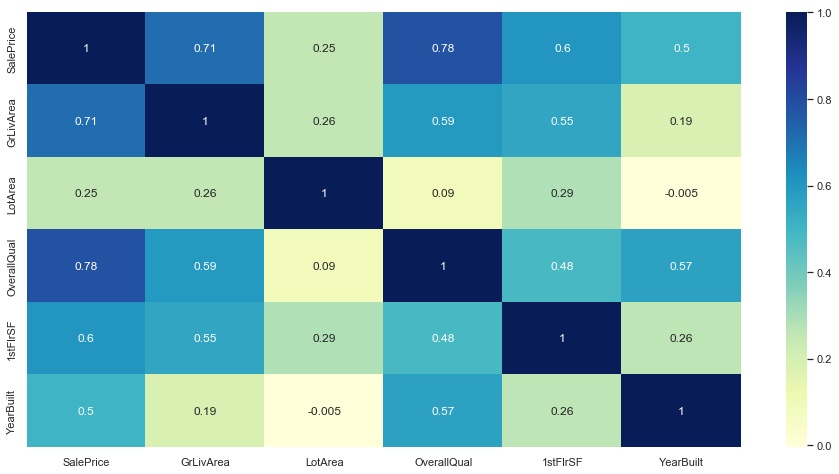

In [87]:
plt.figure(figsize=(16,8))

# heatmap
cor = data[col_list].corr()
sns.heatmap(cor, cmap="YlGnBu", annot=True)
plt.show()

### Correlation analysis
From the above 2 graphs, we can infer that **GrLivArea, OverallQual, 1stFlrSF and YearBuilt** have a greater positive correlation with the **SalePrice**. 

### Creation of dummy variables

There are close to **33** categorical columns, which needs to be converted to dummy variables for us to include them in the training dataset. Upon analyzing these 33 columns, we found that close to **12 of these columns have very high skewed data** i.e more than **80%** of the data is covered by only one category. This will not yield any useful insights and hence would be more practical to remove these columns from the dataset.

In [88]:
# Code to get the total number of categorical columns
grps = data.columns.to_series().groupby(data.dtypes).groups
grps_dict = {k.name: list(v) for k, v in grps.items()}
object_list = grps_dict['object']
print("Total Number of categorical columns are: "+str(len(object_list))+"\n\n")

# Code to display the distribution of the data across their categories for all the categorical columns
grps = data.columns.to_series().groupby(data.dtypes).groups
grps_dict = {k.name: list(v) for k, v in grps.items()}
object_list = grps_dict['object']
for i in object_list:
    print(data[i].value_counts())
    print('\n')
    


Total Number of categorical columns are: 33


RL         1066
RM          191
FV           62
RH           11
C (all)       8
Name: MSZoning, dtype: int64


Reg    829
IR1    459
IR2     40
IR3     10
Name: LotShape, dtype: int64


Lvl    1206
Bnk      52
HLS      48
Low      32
Name: LandContour, dtype: int64


Inside     957
Corner     244
CulDSac     90
FR2         43
FR3          4
Name: LotConfig, dtype: int64


NAmes      209
CollgCr    146
OldTown    100
Somerst     83
Gilbert     77
NridgHt     75
NWAmes      73
Edwards     70
Sawyer      69
SawyerW     53
Crawfor     50
BrkSide     47
Mitchel     42
NoRidge     41
Timber      37
IDOTRR      29
ClearCr     26
StoneBr     25
SWISU       20
Blmngtn     17
BrDale      15
MeadowV     12
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64


Norm      1162
Feedr       63
Artery      43
RRAn        26
PosN        19
RRAe        10
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64


1

### Visualization of the skewed coategorical columns

[Text(0.5, 1.0, 'Distribution for SaleType column')]

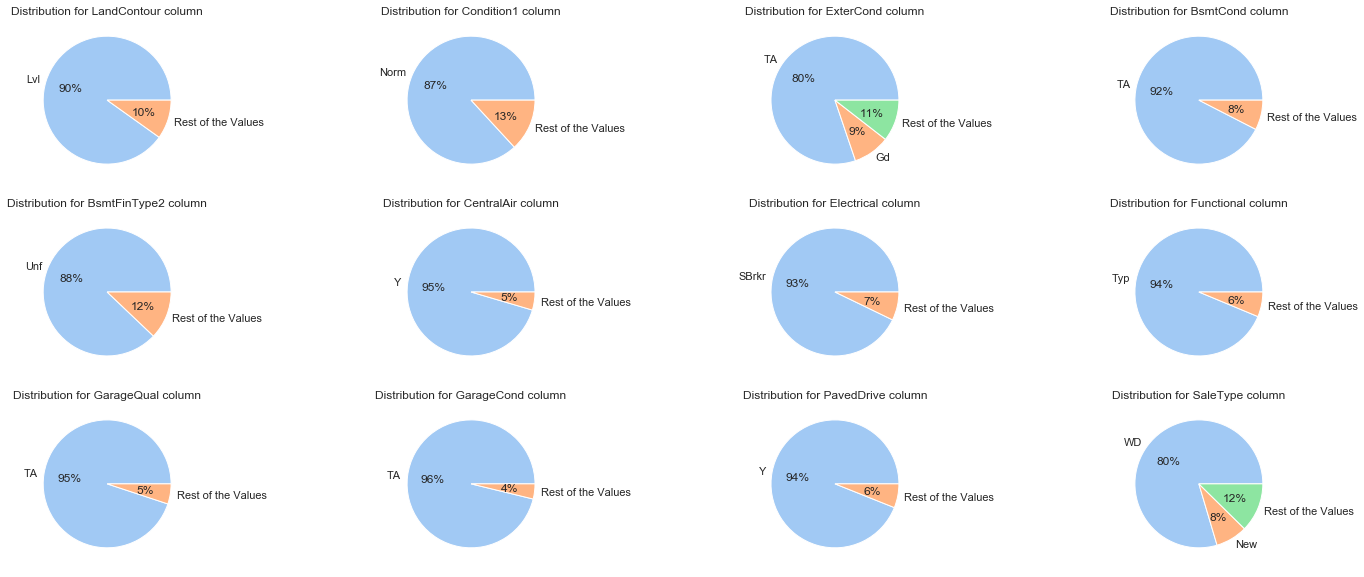

In [89]:

# Code to set the grid for box plots and pie charts
fig, axis = plt.subplots(3,4,figsize=(25, 10))
colors = sns.color_palette('pastel')[0:5]
total = len(data)

# Code go get the params for the pie chart
dat_LandContour, label_LandContour = convert_dat_label(total,data["LandContour"].value_counts()[data["LandContour"].value_counts()>100]) 
dat_Condition1, label_Condition1 = convert_dat_label(total,data["Condition1"].value_counts()[data["Condition1"].value_counts()>100]) 
dat_ExterCond, label_ExterCond = convert_dat_label(total,data["ExterCond"].value_counts()[data["ExterCond"].value_counts()>100]) 
dat_BsmtCond, label_BsmtCond = convert_dat_label(total,data["BsmtCond"].value_counts()[data["BsmtCond"].value_counts()>100]) 
dat_BsmtFinType2, label_BsmtFinType2 = convert_dat_label(total,data["BsmtFinType2"].value_counts()[data["BsmtFinType2"].value_counts()>100]) 
dat_CentralAir, label_CentralAir = convert_dat_label(total,data["CentralAir"].value_counts()[data["CentralAir"].value_counts()>100]) 
dat_Electrical, label_Electrical = convert_dat_label(total,data["Electrical"].value_counts()[data["Electrical"].value_counts()>100])
dat_Functional, label_Functional = convert_dat_label(total,data["Functional"].value_counts()[data["Functional"].value_counts()>100]) 
dat_GarageQual, label_GarageQual = convert_dat_label(total,data["GarageQual"].value_counts()[data["GarageQual"].value_counts()>100]) 
dat_GarageCond, label_GarageCond = convert_dat_label(total,data["GarageCond"].value_counts()[data["GarageCond"].value_counts()>100])
dat_PavedDrive, label_PavedDrive = convert_dat_label(total,data["PavedDrive"].value_counts()[data["PavedDrive"].value_counts()>100]) 
dat_SaleType, label_SaleType = convert_dat_label(total,data["SaleType"].value_counts()[data["SaleType"].value_counts()>100])

# Code to plot the pi chart to capture the skwness of those 3 columns
axis[0,0].pie(list(dat_LandContour),labels=label_LandContour,colors = colors, autopct='%.0f%%')
axis[0,1].pie(list(dat_Condition1),labels=label_Condition1,colors = colors, autopct='%.0f%%')
axis[0,2].pie(list(dat_ExterCond),labels=label_ExterCond,colors = colors, autopct='%.0f%%')
axis[0,3].pie(list(dat_BsmtCond),labels=label_BsmtCond,colors = colors, autopct='%.0f%%')
axis[1,0].pie(list(dat_BsmtFinType2),labels=label_BsmtFinType2,colors = colors, autopct='%.0f%%')
axis[1,1].pie(list(dat_CentralAir),labels=label_CentralAir,colors = colors, autopct='%.0f%%')
axis[1,2].pie(list(dat_Electrical),labels=label_Electrical,colors = colors, autopct='%.0f%%')
axis[1,3].pie(list(dat_Functional),labels=label_Functional,colors = colors, autopct='%.0f%%')
axis[2,0].pie(list(dat_GarageQual),labels=label_GarageQual,colors = colors, autopct='%.0f%%')
axis[2,1].pie(list(dat_GarageCond),labels=label_GarageCond,colors = colors, autopct='%.0f%%')
axis[2,2].pie(list(dat_PavedDrive),labels=label_PavedDrive,colors = colors, autopct='%.0f%%')
axis[2,3].pie(list(dat_SaleType),labels=label_SaleType,colors = colors, autopct='%.0f%%')


axis[0,0].set(title="Distribution for LandContour column")
axis[0,1].set(title="Distribution for Condition1 column")
axis[0,2].set(title="Distribution for ExterCond column")
axis[0,3].set(title="Distribution for BsmtCond column")
axis[1,0].set(title="Distribution for BsmtFinType2 column")
axis[1,1].set(title="Distribution for CentralAir column")
axis[1,2].set(title="Distribution for Electrical column")
axis[1,3].set(title="Distribution for Functional column")
axis[2,0].set(title="Distribution for GarageQual column")
axis[2,1].set(title="Distribution for GarageCond column")
axis[2,2].set(title="Distribution for PavedDrive column")
axis[2,3].set(title="Distribution for SaleType column")




Since the columns **'LandContour', 'Condition1', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'CentralAir', 'Electrical', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType'** have more than 80% of the data dominated by one perticular category, we will delete those columns.

In [90]:
# Code to remove the above mentioned 12 columns
rem_col = ['LandContour', 'Condition1', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'CentralAir', 'Electrical', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType']
data = delCol(data,rem_col)

#Code to display the remaining categorical columns
grps = data.columns.to_series().groupby(data.dtypes).groups
grps_dict = {k.name: list(v) for k, v in grps.items()}
object_list = grps_dict['object']
print("Final list of the "+str(len(object_list))+" categorical columns are dummy variable creation:\n"+ str(object_list))

Final list of the 21 categorical columns are dummy variable creation:
['MSZoning', 'LotShape', 'LotConfig', 'Neighborhood', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageFinish', 'SaleCondition']


For the remaining **21 columns** we will create the **dummy variables** for them, so that we can include them in the final dataset for model building. 

**NOTE**: Once we create the dummy variables, we will remove their respective original categorical columns as they would be redundent if we retain them.

In [91]:
#Code to create dummy variables for the above mentioned 21 columns
for i in object_list:
    temp= pd.get_dummies(data[i],prefix=i,drop_first=True)
    data = pd.concat([data,temp],axis=1)

# Code to remove the original categorical columns whose dummy variables are already created
data = data.loc[:,~data.columns.isin(object_list)]
data.head(3)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,MoSold,YrSold,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Foundation_CBlock,Foundation_PConc,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_No Fireplace,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,1710,1,0,2,1,3,1,8,0,2003,2,548,0,61,0,2,2008,208500,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,1262,0,1,2,0,3,1,6,1,1976,2,460,298,0,0,5,2007,181500,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,1786,1,0,2,1,3,1,6,1,2001,2,608,0,42,0,9,2008,223500,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0


In [92]:
#Code to take the backup of the final set the data, which will be used for th training the models
data_bkp_1 = data.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338 entries, 0 to 1459
Columns: 156 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(2), int64(30), uint8(124)
memory usage: 507.0 KB


# Model Creation

### Final training/testing data summary:
After performing the EDA on the supplied data, we have arrived at **1338 rows** and **156 columns** of data. Of these 154 columns are of datatype Integer, and remaining 2 are of type Float.

We will split the above dataset into Train and Test dataset. The split ratio will be **70:30** across train:test. This will yield **936 records** for training data and **402 records** for the testing data.

In [93]:
## Splitting the data into train and test sets'
from sklearn.model_selection import train_test_split
np.random.seed(0)

data_new = data.copy()
train_x, test_x = train_test_split(data_new, train_size=0.7, test_size=0.3, random_state=10)

### Scaling the train data
Since each of the independent variable's value are at a different range, it would result in creation of an uneven model i.e the mode co-efficients will be more for larger value of the independent variable. Hence it is of atmost importance to scale the data so that they all are at the same level.

We will be using the **MinMaxScaler** from sklearn library.

**NOTE**: We will fit and transform the scaler on only the test data, and will use the same model to transform the test data.

In [94]:
## Scaling the continuous variables
cont_cols = ['MSSubClass','LotFrontage','LotArea','OverallQual','OverallCond','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','MoSold','YrSold','SalePrice']

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_x[cont_cols] = scaler.fit_transform(train_x[cont_cols])

train_x.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,MoSold,YrSold,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Foundation_CBlock,Foundation_PConc,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_No Fireplace,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.00000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.00000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.00000,936.000000,936.000000,936.000000,936.0,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.0,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.0,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,93

### Seperate the Target Variable *SalePrice* from the dataset

In [95]:
# Code to seperate the Target variable from the training dataset
train_y = train_x.pop("SalePrice")

### Scaling the test data

In [96]:
#Scale the test data with the training scaler model
cont_cols = ['MSSubClass','LotFrontage','LotArea','OverallQual','OverallCond','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','MoSold','YrSold','SalePrice']
test_x[cont_cols] = scaler.transform(test_x[cont_cols])

#Seperating the test target variable
test_y = test_x.pop("SalePrice")

### Utility function for evaluation metrics
To evaluate our models, we will use the below list of metrics:
- **R2_Score**
- **Residual Sum of Square (RSS)**
- **Mean Square Error (MSE)**
- **Root Mean Square Error (RMSE)**

We will build a utility function **eval_metrics** that calcuates the above metrics for the supplied actual and predicted values.


In [97]:
# Implementing the Evaluation metrics
def eval_metrics(y,y_pred):
    r2 = r2_score(y, y_pred) # Calculate the r2 score
    rss = np.sum(np.square(y-y_pred)) ## Calculate the residual sum of square
    mse = mean_squared_error(y,y_pred) ## Calculate the Mean Squared Error
    rmse = rmse = mse**0.5 ## Calculate the Root mean Square error
    return (r2, rss, mse, rmse)
    

## Model Selection: Stratergy
Since the target variable is a continuous variable, we would be using the **Linear Regression Models** to predict the Sale Price. While we can use the **LinearRegresion** from sklearn, this might result in overfitting. To avoid that risk, we would like to implement regularization into the linear regression model. 

To implement *regularization*, we will use the below 2 models from sklearn library:
- **Ridge**
- **Lasso**

I would like to implement the above 2 models along with the plain LinearRegression model, and then evaluate each of these models based on their evaluation metrics and the explainibility of these models.

### LinearRegression: Model Implementation

First, we will implement the LinearRegression model without any regularization. For this we will use the LinearRegression function from the sklearn library.
Since we have **156 columns**, it would not be practical to include all these columns in our model prediction. Hence to restrict the model to only a few significant parameters, we will use **RFE technique** of parameter selection. We will choose the list of parameters equal to **15**.

In [98]:
# Building the Linear Regression model
lm = LinearRegression()

# running RFE with 15 variables as output
rfe = RFE(lm, 15)             
rfe = rfe.fit(train_x, train_y)
relev_col = train_x.columns[rfe.support_]

# Fitting the LinearRegression model with the final 15 columns
lm_train_x_final = train_x[relev_col]
lm.fit(lm_train_x_final, train_y)

print("Final 15 list of columns: \n"+str(list(relev_col)))

Final 15 list of columns: 
['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'BsmtFinSF1', 'GrLivArea', 'KitchenAbvGr', 'GarageCars', 'LotShape_IR3', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_StoneBr', 'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA']


### Linear Regression: Model Evaluation

In [99]:
# Predicting the train data
lm_y_train_pred = lm.predict(lm_train_x_final)

# Predicting the test data
lm_test_x_final = test_x[relev_col]
lm_y_test_pred = lm.predict(lm_test_x_final)

train_r2, train_rss, train_mse, train_rmse = eval_metrics(train_y,lm_y_train_pred)
test_r2, test_rss, test_mse, test_rmse = eval_metrics(test_y,lm_y_test_pred)

metric_train_list = [train_r2, train_rss, train_mse, train_rmse]
metric_test_list = [test_r2, test_rss, test_mse, test_rmse]

lm_table = {'Metric': ['R2 Score','RSS','MSE','RMSE'], 
        'LM_Train': metric_train_list,
        'LM_Test': metric_test_list
        }

lr_metric = pd.DataFrame(lm_table ,columns = ['Metric', 'LM_Train', 'LM_Test'] )
lr_metric

,Metric,LM_Train,LM_Test
0,R2 Score,0.822520,0.825687
1,RSS,1.950114,0.886719
2,MSE,0.002083,0.002206
3,RMSE,0.045645,0.046966


### Linear Regression: Residual Analysis
As part of residual analysis for Linear Regression model we will perform the below 3 analysis:
- Validate the normal distribution of the error terms (Distplot of the error term)
- Validate the homoscedasticity of the error term (Scatter plot of error terms along the target variable)
- Validate the independence of the error term (Check for any visible pattern in the scatter plot of error terms vs target variable)

Once the above 3 criterias are validated, we can accpet the Linear regression model that we built.

Text(0.5, 0, 'Errors')

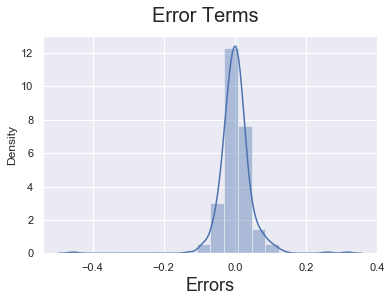

In [100]:
# Test for Normal distribution
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((test_y - lm_y_test_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)  

Text(0, 0.5, 'Residual')

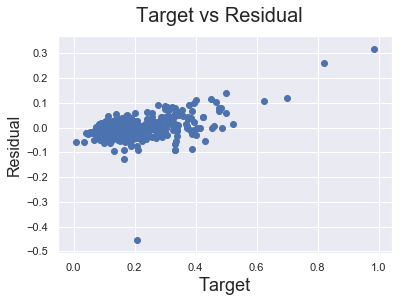

In [101]:
# Test for homoscedasticity and error pattern
fig = plt.figure()
plt.scatter(test_y, (test_y - lm_y_test_pred))
fig.suptitle('Target vs Residual', fontsize = 20)              # Plot heading 
plt.xlabel('Target', fontsize = 18)                          # X-label
plt.ylabel('Residual', fontsize = 16) 

### Linear Regression: co-efficients
Below is the code that extracts the info of the model co-efficients mapped with their column names.

In [102]:
# Code to display the Model co-efficients along with their variable name

temp_dict = { col:coef for coef, col in list(zip(lm.coef_, lm_train_x_final.columns))}
coef_dict = dict(sorted(temp_dict.items(), key=lambda item:abs(item[1]), reverse=True))
final_coef_dict = {k:v for k, v in coef_dict.items()}
value_list = list(final_coef_dict.values())
key_list = list(final_coef_dict.keys())

lm_coef_table = {'Columns': key_list, 
        'Co-Efficients': value_list,
        }

lm_metric = pd.DataFrame(lm_coef_table ,columns = ['Columns', 'Co-Efficients'] )
lm_metric

,Columns,Co-Efficients
0,GrLivArea,0.343921
1,LotArea,0.220013
2,OverallQual,0.170170
3,BsmtFinSF1,0.136116
4,LotShape_IR3,-0.073215
5,GarageCars,0.072894
6,KitchenAbvGr,-0.070574
7,KitchenQual_TA,-0.064305
8,YearBuilt,0.060968
9,KitchenQual_Fa,-0.060344


### Linaer Regression: Conclusion
Below are the observations for the Linear regression model:
- The test accuracy is lower than the training accuracy.
- The R2_score for both test and training dataset is more than **82%** which is acceptable
- The error terms are *Normally ditributed*
- There is no visible pattern in the Residual and also they are range bound expect for very few outlier data points.

From the above observations, the Linear Model does a decent job in predicting the Sale Price. We will compare this with the Lasso and the Ridge regularized models before we finalize.

### RidgeRegression: Model Implementation

We will implement the RidgeRegression model, which is a type of regularization model. For this we will use the Ridge function from the sklearn library.
Since we have **156 columns**, it would not be practical to include all these columns in our model prediction. Hence to restrict the model to only a few significant parameters, we will use **RFE technique** of parameter selection. We will choose the list of parameters equal to **15**. *The reason why we need to use RFE in Ridge scenario is because the regularization implemented by Ridge doesn't pull the insignificant model parameters to zero*.

Also, what i observed was that the RFE column list changes with the change in the alpha value. Due to this, we wont be able to use the GridSearch, as GridSearch would require a fixed number of variables to perform HyperParamter tuning. Hence we will write a script that will loop through the list of interested alpha values, then manually choose the best alpha value possible.


In [103]:
## Implementing the ridge regression 

r2_list, rss_list, mse_list, rmse_list = [], [], [], []

lambdas = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 10, 100, 1000] 
for i in lambdas:
    ridgereg = Ridge(alpha = i) # Initialize the Ridge Regression model with a specific lambda
    rfe = RFE(ridgereg, 15)             # running RFE with 15 variables as output
    rfe = rfe.fit(train_x, train_y)
    relev_col = train_x.columns[rfe.support_]
    
    train_x_final = train_x[relev_col]
    ridgereg.fit(train_x_final, train_y)
    
    y_pred = ridgereg.predict(train_x_final)
    r2, rss, mse, rmse = eval_metrics(train_y,y_pred)
    r2_list.append(r2)
    rss_list.append(rss)
    mse_list.append(mse)
    rmse_list.append(rmse)

ridge_metrics_table = {'Alpha': lambdas, 
        'R2': r2_list,
        'RSS': rss_list,
        'MSE': mse_list,
        'RMSE': rmse_list
        }

ridge_alpha_metrics_table = pd.DataFrame(ridge_metrics_table ,columns = ['Alpha', 'R2', 'RSS', 'MSE', 'RMSE'] )
ridge_alpha_metrics_table   

,Alpha,R2,RSS,MSE,RMSE
0,0.0001,0.810799,2.078901,0.002221,0.047128
1,0.0010,0.810799,2.078901,0.002221,0.047128
2,0.0100,0.820983,1.967006,0.002102,0.045842
3,0.1000,0.820953,1.967334,0.002102,0.045846
4,0.5000,0.818318,1.996285,0.002133,0.046182
5,1.0000,0.814373,2.039628,0.002179,0.046681
6,10.0000,0.806126,2.130253,0.002276,0.047707
7,100.0000,0.687052,3.438607,0.003674,0.060611
8,1000.0000,0.412078,6.459977,0.006902,0.083076


After performing the above activity, we found that alpha of **0.1** is the optimal Alpha which yields the highest R2 score. 

In [105]:
# Code to build the ridge model  for alpha=0.1
ridgereg = Ridge(alpha = 0.1) # Initialize the Ridge Regression model with a specific lambda
rfe = RFE(ridgereg, 15)             # running RFE with 15 variables as output
rfe = rfe.fit(train_x, train_y)
relev_col = train_x.columns[rfe.support_]

ridge_train_x_final = train_x[relev_col]
ridgereg.fit(ridge_train_x_final, train_y)

print("Final 15 list of columns: \n"+str(list(relev_col)))

Final 15 list of columns: 
['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', '1stFlrSF', 'GrLivArea', 'KitchenAbvGr', 'GarageCars', 'LotShape_IR3', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_StoneBr', 'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA']


### Ridge Regression: Model Evaluation

In [106]:
# Predicting the train data
ridge_y_train_pred = ridgereg.predict(ridge_train_x_final)

# Predicting the test data
ridge_test_x_final = test_x[relev_col]
ridge_y_test_pred = ridgereg.predict(ridge_test_x_final)

train_r2, train_rss, train_mse, train_rmse = eval_metrics(train_y,ridge_y_train_pred)
test_r2, test_rss, test_mse, test_rmse = eval_metrics(test_y,ridge_y_test_pred)

metric_train_list = [train_r2, train_rss, train_mse, train_rmse]
metric_test_list = [test_r2, test_rss, test_mse, test_rmse]

ridge_table = {'Metric': ['R2 Score','RSS','MSE','RMSE'], 
        'Ridge_Train': metric_train_list,
        'Ridge_Test': metric_test_list
        }

ridge_metric = pd.DataFrame(ridge_table ,columns = ['Metric', 'Ridge_Train', 'Ridge_Test'] )
ridge_metric

,Metric,Ridge_Train,Ridge_Test
0,R2 Score,0.820953,0.823735
1,RSS,1.967334,0.896649
2,MSE,0.002102,0.002230
3,RMSE,0.045846,0.047228


### Ridge Regression: Residual Analysis
As part of residual analysis for Ridge Regression model we will perform the below 3 analysis:
- Validate the normal distribution of the error terms (Distplot of the error term)
- Validate the homoscedasticity of the error term (Scatter plot of error terms along the target variable)
- Validate the independence of the error term (Check for any visible pattern in the scatter plot of error terms vs target variable)

Once the above 3 criterias are validated, we can accpet the Ridge regression model that we built.

Text(0.5, 0, 'Errors')

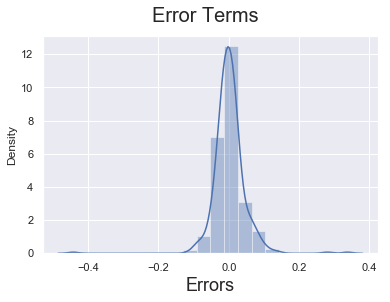

In [107]:
# Test for Normal distribution
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((test_y - ridge_y_test_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)  

Text(0, 0.5, 'Residual')

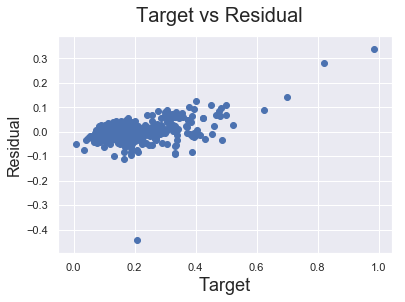

In [108]:
# Test for homoscedasticity and error pattern
fig = plt.figure()
plt.scatter(test_y, (test_y - ridge_y_test_pred))
fig.suptitle('Target vs Residual', fontsize = 20)              # Plot heading 
plt.xlabel('Target', fontsize = 18)                          # X-label
plt.ylabel('Residual', fontsize = 16) 

### Ridge co-efficients
Below is the code that extracts the info of the model co-efficients mapped with their column names.

In [109]:
# Code to display the Model co-efficients along with their variable name

temp_dict = { col:coef for coef, col in list(zip(ridgereg.coef_, ridge_train_x_final.columns))}
coef_dict = dict(sorted(temp_dict.items(), key=lambda item:abs(item[1]), reverse=True))
final_coef_dict = {k:v for k, v in coef_dict.items() if v!=0}
value_list = list(final_coef_dict.values())
key_list = list(final_coef_dict.keys())

ridge_coef_table = {'Columns': key_list, 
        'Co-Efficients': value_list,
        }

ridge_metric = pd.DataFrame(ridge_coef_table ,columns = ['Columns', 'Co-Efficients'] )
ridge_metric

,Columns,Co-Efficients
0,GrLivArea,0.307567
1,LotArea,0.207098
2,OverallQual,0.156561
3,1stFlrSF,0.130853
4,KitchenAbvGr,-0.075735
5,YearBuilt,0.072945
6,GarageCars,0.067567
7,OverallCond,0.067270
8,KitchenQual_TA,-0.064937
9,Neighborhood_StoneBr,0.062527


### Ridge Regression: Conclusion
Below are the observations for the Ridge regression model:
- The test accuracy is lower than the training accuracy.
- The R2_score for both test and training dataset is more than **82%** which is acceptable
- The error terms are *Normally ditributed*
- There is no visible pattern in the Residual and also they are range bound expect for very few outlier data points.
- There is *hardly any difference between the Training R2_score and Testing R2_score*. This is a very good indicator of the fact that ridge regression has been able to solve the problem of overfitting.

From the above observations, the Ridge Model does a decent job in predicting the Sale Price. We will compare this with the Lasso regularized models before we finalize.

### Lasso Regression: Model Implementation

We will implement the Lasso Regression model, which is a type of regularization model. For this we will use the Lasso function from the sklearn library.
One of the standout features of the Lasso regression, unlike Ridge Regression, is the capability of Lasso models to pull the insignificant variables to 0. Doing so, we dont have a manually eliminate those insignificant parameters and hence, we dont need to use parameter selection techniques like RFE. 

For Lasso regression, we need to tune the hyperparameter *alpha*, for which we will use the GridSearchCV functionality from the Sklearn library

### Lasso Regression: Hyperparameter **Alpha** tuning

In [110]:
params = {'alpha': [0.00005, 0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

lasso = Lasso()

# cross validation
folds = 5
lasso_model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'r2',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)  
lasso_train_x_final = train_x
lasso_model_cv.fit(lasso_train_x_final, train_y) 

# Printing the best hyperparameter alpha
print(lasso_model_cv.best_params_)

Fitting 5 folds for each of 29 candidates, totalling 145 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'alpha': 0.0001}


[Parallel(n_jobs=1)]: Done 145 out of 145 | elapsed:    0.7s finished


Afer performing the GridSearch, we found that alpha of 0.0001 is the optimal Alpha which yields the highest R2 score. 

In [111]:
# Code to build the Lasso model with alpha=0.0001
lasso = Lasso(alpha = 0.0001)

lasso_train_x_final = train_x
lasso.fit(lasso_train_x_final, train_y)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

### Lasso Regression: Model Evaluation

In [112]:
# Predicting the train data
lasso_y_train_pred = lasso.predict(lasso_train_x_final)

# Predicting the test data
lasso_test_x_final = test_x
lasso_y_test_pred = lasso.predict(lasso_test_x_final)

train_r2, train_rss, train_mse, train_rmse = eval_metrics(train_y,lasso_y_train_pred)
test_r2, test_rss, test_mse, test_rmse = eval_metrics(test_y,lasso_y_test_pred)

metric_train_list = [train_r2, train_rss, train_mse, train_rmse]
metric_test_list = [test_r2, test_rss, test_mse, test_rmse]

lasso_table = {'Metric': ['R2 Score','RSS','MSE','RMSE'], 
        'Lasso_Train': metric_train_list,
        'Lasso_Test': metric_test_list
        }

lasso_metric = pd.DataFrame(lasso_table ,columns = ['Metric', 'Lasso_Train', 'Lasso_Test'] )
lasso_metric

,Metric,Lasso_Train,Lasso_Test
0,R2 Score,0.879813,0.852971
1,RSS,1.320593,0.747926
2,MSE,0.001411,0.001861
3,RMSE,0.037562,0.043134


### Lasso Regression: Residual Analysis
As part of residual analysis for Lasso Regression model we will perform the below 3 analysis:
- Validate the normal distribution of the error terms (Distplot of the error term)
- Validate the homoscedasticity of the error term (Scatter plot of error terms along the target variable)
- Validate the independence of the error term (Check for any visible pattern in the scatter plot of error terms vs target variable)

Once the above 3 criterias are validated, we can accpet the Lasso regression model that we built.

Text(0.5, 0, 'Errors')

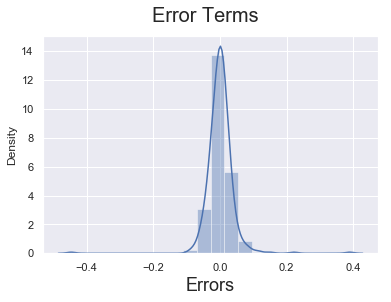

In [113]:
# Test for Normal distribution
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((test_y - lasso_y_test_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)  

Text(0, 0.5, 'Residual')

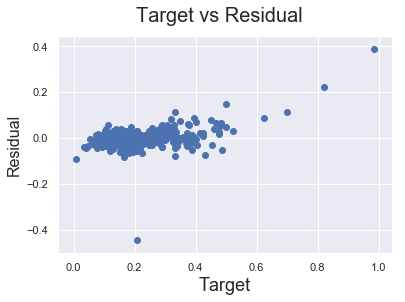

In [114]:
# Test for homoscedasticity and error pattern
fig = plt.figure()
plt.scatter(test_y, (test_y - lasso_y_test_pred))
fig.suptitle('Target vs Residual', fontsize = 20)              # Plot heading 
plt.xlabel('Target', fontsize = 18)                          # X-label
plt.ylabel('Residual', fontsize = 16) 

### Lasso co-efficients
Upon mapping the columns names with their respective model co-efficients, and then filtering out all the zero co-efficient columns, we find that there are **67 non-zero co-efficients**.
Below is the code that extracts the above info, and displays the independent variable-Co-efficients mapping

In [115]:
# Code to display the Model co-efficients along with their variable name

temp_dict = { col:coef for coef, col in list(zip(lasso.coef_, lasso_train_x_final.columns))}
coef_dict = dict(sorted(temp_dict.items(), key=lambda item:abs(item[1]), reverse=True))
final_coef_dict = {k:v for k, v in coef_dict.items() if v!=0}
value_list = list(final_coef_dict.values())
key_list = list(final_coef_dict.keys())

lasso_coef_table = {'Columns': key_list, 
        'Co-Efficients': value_list,
        }

lasso_metric = pd.DataFrame(lasso_coef_table ,columns = ['Columns', 'Co-Efficients'] )
lasso_metric

,Columns,Co-Efficients
0,GrLivArea,0.266289
1,OverallQual,0.124901
2,Neighborhood_NoRidge,0.060926
3,LotArea,0.059116
4,Neighborhood_StoneBr,0.057921
5,GarageCars,0.054553
6,Neighborhood_NridgHt,0.046750
7,OverallCond,0.043271
8,BsmtExposure_Gd,0.037274
9,ExterQual_Fa,-0.036802


### Lasso Regression: Conclusion
Below are the observations for the Linear regression model:
- The test accuracy is lower than the training accuracy.
- The R2_score for both test and training dataset is more than **85%** which is acceptable
- There are close to 100 model co-efficients selected by the lasso models.
- The error terms are *Normally ditributed*
- There is no visible pattern in the Residual and also they are range bound expect for very few outlier data points.

From the above observations, the Linear Model does a decent job in predicting the Sale Price. We will compare this with the Lasso and the Ridge regularized models before we finalize.

# Model Finalization

After training the train data and predicting the test data with the **Linear Regression model, Ridge Regression model and Lasso Regression model**, i would like to share the below analysis:
- **Linear regression model with 15 variables count**, yield a train and test R2_Score of **82%** . The R2_Score is pretty high, and the difference between train and test data is neglegible. This makes the Linear regression model a strong contender to make it to the final model.
- **Lasso regression model** din't require any feature selection technique as it had the inherent capability to exclude the insignificant variable by pulling their co-efficients to zero. While the train and test r2_score was **87% and 85%** respectively,which is higher than the Linear regression, there are 2 apparent issues here:
    1. There is difference in R2_score of the train and the test data. This points out a **strong possibility of overfitting**.
    2. The major reason for higher R2_score is due to the fact that Lasso model has close to **67 variables** included in them. This eventually will add to the R2_score. But when it comes to explainibility, this model is not best suited as it will not make much sense to involve 67 odd varaibles in the final interpretation.
- **Ridge Regression model** did require feature selection technique, as with Linear regression model, but with 15 variables, i was able to achieve R2_score of **82%** on both train and test dataset. This is a very good model considering that there is no scope for over-fitting or under-fitting. Also, the fact that this has the flexibility of adding more regularization affect makes this model more robust.

After consider the above findings, i would prefer to finalize the **Ridge regression model** for predicting the Sale Price of the house.

## Model Interpretation

With the **Ridge regression model** finalized, i would like to present the model interpretation.

The model will follow th equation: **SalePrice = 0.307567*GrLivArea + 0.207098*LotArea + 0.156561*OverallQual + 0.130853*1stFlrSF - 0.075735*KitchenAbvGr + 0.072945*YearBuilt + 0.067567*GarageCars + 0.067270*OverallCond - 0.064937*KitchedQualTA + 0.062527*Neighbourhood_StoneBR + 0.061766*Neighbourhood_NoRidge - 0.060925*KitchenQual_FA - 0.059986*Lotshape_IR3 - 0.059970*KitchenQual_GD + 0.058434*Neighborhood_NridgHt**

From the above equation we can see that **Above ground living area (GrLivArea), Lot Area, Overall material and finish of the house (OverallQual), 1st floor square feet (1FlrSF) have a higher positive correlation with the house price**. 

To put the above analysis into practical interpretation, while keeping all the factors constant, **an increase in Above ground living area by 1 units will increase the SalePrice by 0.30 unit**. Similarly, **an increase in Lot Area by 1 unit will increase the SalePrice by 0.2 unit, keepin all the other variables constant**.